In [15]:
!pip install ultralytics torch torchvision tqdm --quiet
import os
import shutil
from pathlib import Path
import glob
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import models, transforms, datasets
import pandas as pd
from ultralytics import YOLO
from PIL import Image
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns


# display settings
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (8,5)


In [13]:
# CHANGE THIS if your path is different
ROOT_DIR = "/kaggle/input/tomato-dataset/Tomato"

SPLITS = ["train", "valid", "test"]

paths = {
    split: {
        "images": os.path.join(ROOT_DIR, split, "images"),
        "labels": os.path.join(ROOT_DIR, split, "labels"),
    }
    for split in SPLITS
}

# 0–9 class ids in this exact order (your list)
CLASS_NAMES = [
    "Bacterial Spot",
    "Early Blight",
    "Healthy",
    "Late Blight",
    "Leaf Mold",
    "Leaf_Miner",
    "Mosaic Virus",
    "Septoria",
    "Spider Mites",
    "Yellow Leaf Curl Virus",
]
id2name = {i: n for i, n in enumerate(CLASS_NAMES)}

print(id2name)


{0: 'Bacterial Spot', 1: 'Early Blight', 2: 'Healthy', 3: 'Late Blight', 4: 'Leaf Mold', 5: 'Leaf_Miner', 6: 'Mosaic Virus', 7: 'Septoria', 8: 'Spider Mites', 9: 'Yellow Leaf Curl Virus'}


In [16]:
img_records = []
label_records = []

for split in SPLITS:
    img_dir = paths[split]["images"]
    lbl_dir = paths[split]["labels"]
    img_files = sorted(glob.glob(os.path.join(img_dir, "*")))
    
    print(f"Scanning {split} ({len(img_files)} images)...")
    
    # ---- image metadata ----
    for img_path in tqdm(img_files):
        img_id = os.path.splitext(os.path.basename(img_path))[0]
        try:
            with Image.open(img_path) as im:
                w, h = im.size
        except:
            w = h = np.nan
        img_records.append({
            "split": split,
            "image_id": img_id,
            "image_path": img_path,
            "width": w,
            "height": h,
            "aspect": w / h if (w and h) else np.nan,
            "area": w * h if (w and h) else np.nan,
        })
    
    # ---- label metadata (YOLO format) ----
    label_files = sorted(glob.glob(os.path.join(lbl_dir, "*.txt")))
    for lbl_path in label_files:
        img_id = os.path.splitext(os.path.basename(lbl_path))[0]
        with open(lbl_path, "r") as f:
            for line in f:
                line = line.strip()
                if not line:
                    continue
                parts = line.split()
                cls = int(parts[0])
                x_c, y_c, bw, bh = map(float, parts[1:5])  # normalized
                
                label_records.append({
                    "split": split,
                    "image_id": img_id,
                    "label_path": lbl_path,
                    "class_id": cls,
                    "class_name": id2name.get(cls, f"cls_{cls}"),
                    "x_center": x_c,
                    "y_center": y_c,
                    "width_n": bw,
                    "height_n": bh,
                    "box_area_n": bw * bh,
                })

df_imgs   = pd.DataFrame(img_records)
df_labels = pd.DataFrame(label_records)

print("\nImages df shape:", df_imgs.shape)
print("Labels df shape:", df_labels.shape)
df_imgs.head(), df_labels.head()


Scanning train (18366 images)...


100%|██████████| 18366/18366 [00:15<00:00, 1183.51it/s]


Scanning valid (1675 images)...


100%|██████████| 1675/1675 [00:01<00:00, 1253.14it/s]


Scanning test (637 images)...


100%|██████████| 637/637 [00:00<00:00, 1186.90it/s]



Images df shape: (20678, 7)
Labels df shape: (45388, 10)


(   split                                           image_id  \
 0  train      00009_jpg.rf.44f3c5cb66c937e18119e886f2a19ab8   
 1  train      00009_jpg.rf.af5692a137f0220cb91c8f82f1b45e78   
 2  train      00009_jpg.rf.f6792833777d493c67680b5c8191298a   
 3  train  0045ba29-ed1b-43b4-afde-719cc7adefdb___GCREC_B...   
 4  train  0045ba29-ed1b-43b4-afde-719cc7adefdb___GCREC_B...   
 
                                           image_path  width  height  aspect  \
 0  /kaggle/input/tomato-dataset/Tomato/train/imag...    512     512     1.0   
 1  /kaggle/input/tomato-dataset/Tomato/train/imag...    512     512     1.0   
 2  /kaggle/input/tomato-dataset/Tomato/train/imag...    512     512     1.0   
 3  /kaggle/input/tomato-dataset/Tomato/train/imag...    512     512     1.0   
 4  /kaggle/input/tomato-dataset/Tomato/train/imag...    512     512     1.0   
 
      area  
 0  262144  
 1  262144  
 2  262144  
 3  262144  
 4  262144  ,
    split                                           i

In [17]:
print("=== Images per split ===")
display(df_imgs.groupby("split")["image_id"].nunique().to_frame("num_images"))

print("\n=== Boxes per split ===")
display(df_labels.groupby("split")["class_id"].count().to_frame("num_boxes"))

# images that have at least one label
labeled_imgs = df_labels.drop_duplicates(["split","image_id"]) \
                        .groupby("split")["image_id"].count()
print("\n=== Labeled images per split ===")
display(labeled_imgs.to_frame("labeled_images"))


=== Images per split ===


,num_images
split,
test,637
train,18366
valid,1675



=== Boxes per split ===


,num_boxes
split,
test,1824
train,40003
valid,3561



=== Labeled images per split ===


,labeled_images
split,
test,637
train,18354
valid,1674


In [18]:
# images with zero labels
zero_labels = []

for split in ["train","valid","test"]:
    img_ids = set(df_imgs[df_imgs.split == split].image_id)
    lbl_ids = set(df_labels[df_labels.split == split].image_id)
    
    zero_split = img_ids - lbl_ids
    print(f"{split}: zero-label images = {len(zero_split)}")
    
    zero_labels.extend([(split, img) for img in zero_split])


train: zero-label images = 12
valid: zero-label images = 1
test: zero-label images = 0


In [19]:
# unlabeled images(rare but should be considered)
zero_df = df_imgs.merge(
    df_labels[["split","image_id"]].drop_duplicates(),
    on=["split","image_id"],
    how="left",
    indicator=True
)

df_clean = zero_df[zero_df["_merge"] == "both"].drop(columns="_merge")

print("Original:", len(df_imgs))
print("After dropping:", len(df_clean))


Original: 20678
After dropping: 20665


In [20]:
multiclass = df_labels.groupby(["split","image_id"])["class_id"].nunique()
print(multiclass.value_counts())


class_id
1    19902
2      741
3       22
Name: count, dtype: int64


In [21]:
# 1) Count how many unique classes per (split, image_id)
multi = (
    df_labels
    .groupby(["split", "image_id"])["class_id"]
    .nunique()
    .reset_index(name="n_classes")
)

print(multi["n_classes"].value_counts())


n_classes
1    19902
2      741
3       22
Name: count, dtype: int64


In [22]:
# 2) Keep only single-class image IDs
single_ids = multi[multi["n_classes"] == 1][["split", "image_id"]]

print("Single-class images:", len(single_ids))


Single-class images: 19902


In [24]:
# Filter labels to single-class images
df_labels_single = df_labels.merge(single_ids, on=["split", "image_id"], how="inner")

# Filter images to single-class images
df_imgs_single = df_imgs.merge(single_ids, on=["split", "image_id"], how="inner")

print("df_labels_single:", df_labels_single.shape)
print("df_imgs_single :", df_imgs_single.shape)
#Use df_labels_single and df_imgs_single for EDA

df_labels_single: (38403, 10)
df_imgs_single : (19902, 7)


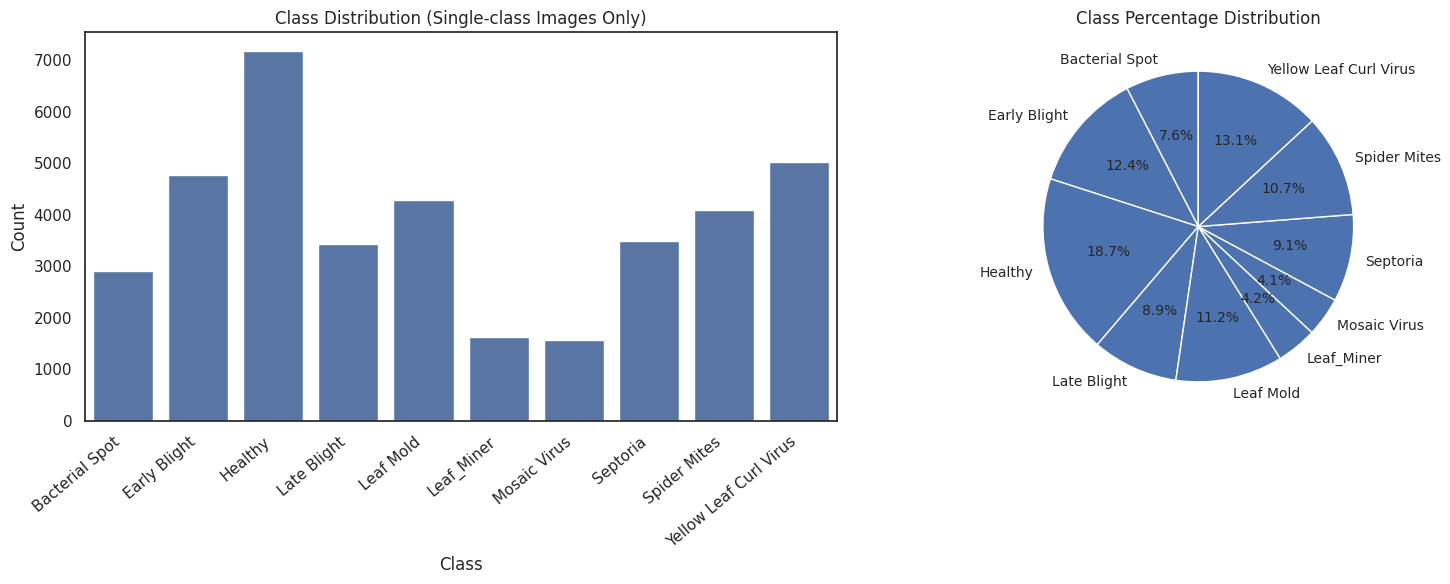

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count per class (single-class only)
class_counts = (
    df_labels_single["class_id"]
    .value_counts()
    .sort_index()
)

labels = [
    "Bacterial Spot","Early Blight","Healthy","Late Blight","Leaf Mold",
    "Leaf_Miner","Mosaic Virus","Septoria","Spider Mites","Yellow Leaf Curl Virus"
]

# Minimal style
sns.set_style("white")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# ---- Bar plot ----
sns.countplot(
    data=df_labels_single,
    x="class_id",
    order=sorted(df_labels_single["class_id"].unique()),
    color="#4C72B0",   # soft blue
    ax=ax1
)

ax1.set_xticks(range(10))
ax1.set_xticklabels(labels, rotation=40, ha="right")
ax1.set_title("Class Distribution (Single-class Images Only)")
ax1.set_ylabel("Count")
ax1.set_xlabel("Class")
ax1.grid(False)        # turn off grid lines

# ---- Pie chart ----
ax2.pie(
    class_counts.values,
    labels=labels,
    autopct=lambda p: f'{p:.1f}%',
    startangle=90,
    colors=["#4C72B0"] * len(labels),  # same soft blue
    wedgeprops={"edgecolor": "white"},
    textprops={'fontsize': 10}
)
ax2.set_title("Class Percentage Distribution")

plt.tight_layout()
plt.show()


In [ ]:
print(class_counts)

In [ ]:
target = {
    2: 6913,   # Healthy
    1: 4224,   # Early Blight
    3: 4224,   # Late Blight
    7: 3840,   # Septoria
    0: 3840,   # Bacterial Spot
    9: 4992,   # Yellow Leaf Curl
    4: 3072,   # Leaf Mold
    6: 2688,   # Mosaic Virus
    5: 2304,   # Leaf Miner
    8: 2304,   # Spider Mites
}

current = df_labels_single["class_id"].value_counts().sort_index().to_dict()

adjustments = {cid: target[cid] - current.get(cid,0) for cid in target}

import pandas as pd
pd.DataFrame([
    {"class_id":cid, "class_name":CLASS_NAMES[cid], "current":current[cid], "target":target[cid], "adjust":adjustments[cid]}
    for cid in target
])


In [ ]:
# Path to your leaf detector
leaf_model_path = "/kaggle/input/yolo-leaf-detection-model/pytorch/default/1/best.pt"  # change if needed

device = "cuda" if torch.cuda.is_available() else "cpu"
leaf_detector = YOLO(leaf_model_path)
leaf_detector.to(device)
leaf_detector.eval()


In [ ]:
# If your image dataframe column is 'path' instead of 'image_path', uncomment this:
# df_imgs_single = df_imgs_single.rename(columns={"path": "image_path"})

df_merged = df_imgs_single.merge(
    df_labels_single[["split", "image_id", "class_id"]].drop_duplicates(),
    on=["split", "image_id"],
    how="inner"
)

print(df_merged.head())
print(df_merged.columns)
print("Total merged rows:", len(df_merged))


In [ ]:
from pathlib import Path
from PIL import Image
import numpy as np
from tqdm import tqdm
import torchvision.transforms.functional as TF

CROP_ROOT = Path("leaf_crops_fixed")
CROP_SIZE = 224
CROP_ROOT.mkdir(exist_ok=True)

# Make folder structure
for split in ["train", "valid", "test"]:
    for cname in CLASS_NAMES:
        (CROP_ROOT / split / cname).mkdir(parents=True, exist_ok=True)


def crop_or_fallback(img, box, crop_size=CROP_SIZE):
    """Crop using YOLO box or fallback to center-crop full image."""
    if box is not None:
        x1, y1, x2, y2 = map(int, box)
        leaf = img.crop((x1, y1, x2, y2))
        leaf = leaf.resize((crop_size, crop_size), Image.BILINEAR)
        return leaf
    else:
        # fallback → center crop full image
        w, h = img.size
        side = min(w, h)
        cx, cy = w // 2, h // 2
        half = side // 2
        leaf = img.crop((cx - half, cy - half, cx + half, cy + half))
        leaf = leaf.resize((crop_size, crop_size), Image.BILINEAR)
        return leaf


def process_images(df):
    skipped = 0
    fallback_used = 0
    successful = 0

    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Processing"):
        img_path = row["image_path"]
        split = row["split"]
        class_id = int(row["class_id"])
        class_name = id2name[class_id]

        try:
            img = Image.open(img_path).convert("RGB")
        except:
            skipped += 1
            continue

        # YOLO inference
        results = leaf_detector(
            source=str(img_path),
            conf=0.25,
            verbose=False,
            device=device
        )

        box = None
        if len(results) > 0 and results[0].boxes is not None and len(results[0].boxes) > 0:
            boxes = results[0].boxes.xyxy.cpu().numpy()
            confs = results[0].boxes.conf.cpu().numpy()

            # pick top-1 highest confidence
            top_idx = np.argmax(confs)
            box = boxes[top_idx]  # (x1,y1,x2,y2)

        else:
            fallback_used += 1

        leaf = crop_or_fallback(img, box, crop_size=CROP_SIZE)

        # save
        out_dir = CROP_ROOT / split / class_name
        fname = f"{row['image_id']}.jpg"
        leaf.save(out_dir / fname)
        successful += 1

    print(f"Processed: {successful}")
    print(f"Fallback used: {fallback_used}")
    print(f"Skipped (load errors): {skipped}")


# Run
process_images(df_merged[df_merged["split"] == "train"])
process_images(df_merged[df_merged["split"] == "valid"])
process_images(df_merged[df_merged["split"] == "test"])


In [ ]:
CROP_ROOT = Path("/kaggle/working/leaf_crops_fixed")

train_dir = CROP_ROOT / "train"
val_dir   = CROP_ROOT / "valid"
test_dir  = CROP_ROOT / "test"

# ImageNet normalization (standard for ResNet)
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])


In [ ]:
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
val_dataset   = datasets.ImageFolder(val_dir,   transform=val_transform)
test_dataset  = datasets.ImageFolder(test_dir,  transform=val_transform)

batch_size = 32  # reduce to 16 if you get OOM
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                          num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False,
                          num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False,
                          num_workers=2, pin_memory=True)

print("Classes:", train_dataset.classes)
print("num_classes:", len(train_dataset.classes))


In [ ]:
# Get label list from ImageFolder
all_targets = [label for _, label in train_dataset.samples]
class_counts = Counter(all_targets)
num_classes = len(train_dataset.classes)
total_samples = len(all_targets)

print("Class counts (train crops):")
for cls_idx in range(num_classes):
    print(f"{train_dataset.classes[cls_idx]:25s}: {class_counts[cls_idx]}")

# weight = total / count  → rarer classes get higher weight
weights = [total_samples / class_counts[i] for i in range(num_classes)]
class_weights = torch.tensor(weights, dtype=torch.float32).to(device)

print("\nClass weights:", class_weights)


In [ ]:
resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

# Option 1: fine-tune everything:
for param in resnet.parameters():
    param.requires_grad = True

# Replace final layer to match your disease classes
in_features = resnet.fc.in_features
resnet.fc = nn.Linear(in_features, num_classes)

resnet = resnet.to(device)


In [ ]:
criterion = nn.CrossEntropyLoss(weight=class_weights)  # handle imbalance

optimizer = optim.Adam(resnet.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.3,
    patience=3
)



In [ ]:
import copy
from tqdm import tqdm

def train_model(model, criterion, optimizer, scheduler, num_epochs=15):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_loss = float("inf")

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 20)

        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
                loader = train_loader
            else:
                model.eval()
                loader = val_loader

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in tqdm(loader, desc=phase):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels)

            epoch_loss = running_loss / len(loader.dataset)
            epoch_acc  = running_corrects.double() / len(loader.dataset)

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            if phase == "val":
                scheduler.step(epoch_loss)

                # save best model on lowest validation loss
                if epoch_loss < best_val_loss:
                    best_val_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    torch.save(best_model_wts, "best_resnet_leaf_disease.pt")
                    print("✅ Saved new best model (val loss improved).")

    print(f"\nBest val loss: {best_val_loss:.4f}")
    model.load_state_dict(best_model_wts)
    return model

resnet = train_model(resnet, criterion, optimizer, scheduler, num_epochs=15)


In [ ]:
def evaluate(model, loader):
    model.eval()
    running_corrects = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="test"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            running_corrects += torch.sum(preds == labels)
            all_labels.extend(labels.cpu().numpy().tolist())
            all_preds.extend(preds.cpu().numpy().tolist())

    acc = running_corrects.double() / len(loader.dataset)
    print(f"Test Accuracy: {acc:.4f}")
    return np.array(all_labels), np.array(all_preds)

y_true, y_pred = evaluate(resnet, test_loader)


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=False, cmap="Blues",
            xticklabels=train_dataset.classes,
            yticklabels=train_dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_true, y_pred, target_names=train_dataset.classes))
